The FinBERT pretrained model can be fine-tuned on downstream financial NLP tasks. This notebook illustrates the process of fine-tuning FinBERT using Huggingface 🤗's tranformers library. You can modify this notebook accordingly to meet you needs.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

!pip install transformers 
!pip install datasets
import numpy as np
import pandas as pd 
from transformers import BertTokenizer, Trainer, BertForSequenceClassification, TrainingArguments
from datasets import Dataset
import torch
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score

# tested in transformers==4.18.0, pytorch==1.7.1 
import torch
import transformers
torch.__version__, transformers.__version__

torch.cuda.is_available()

Mounted at /content/drive
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.7 MB 26.8 MB/s 
     |████████████████████████████████| 596 kB 9.4 MB/s 
     |████████████████████████████████| 101 kB 5.7 MB/s 
     |████████████████████████████████| 6.6 MB 60.9 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 32.8 MB/s 
     |████████████████████████████████| 141 kB 69.6 MB/s 
     |████████████████████████████████| 115 kB 69.8 MB/s 
     |████████████████████████████████| 212 kB 74.0 MB/s 
     |████████████████████████████████| 127 kB 67.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.

True

### Load and process the dataset

In [2]:
from sklearn.preprocessing import LabelEncoder


df = pd.read_csv('my_dataset.csv') ## use your own customized dataset
df = df.dropna(subset=['sentence', 'label']) ## drop missing values
df = df[['sentence', 'label']] ## keep only features of interest

print("Imbalanced dataset: ")
print(df['label'].value_counts())

#Get 500 samples from each class, to decrease imbalance
# df=df.groupby('label',as_index = False,group_keys=False).apply(lambda s: s.sample(500,replace=False)).sample(frac=1)
df = df.sample(frac=1.0).reset_index().drop('index', axis = 1)


print("Balanced dataset: ")
print(df['label'].value_counts())


#Encode the text lables into numbers
le = LabelEncoder().fit(df['label'])
df['label'] = le.transform(df['label'])



Imbalanced dataset: 
PL    500
CR    500
CC    500
NC    500
HC    500
BE    500
PW    500
CG    500
N     500
Name: label, dtype: int64
Balanced dataset: 
HC    500
CR    500
CC    500
NC    500
BE    500
CG    500
PW    500
PL    500
N     500
Name: label, dtype: int64


#Load FinBeRT model

In [3]:

num_labels = len( set(df['label']))

model = BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [4]:


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {'accuracy' : accuracy_score(predictions, labels)}


args = TrainingArguments(
        output_dir = 'temp/',
        evaluation_strategy = 'epoch',
        save_strategy = 'epoch',
        learning_rate=2e-5,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=32,
        num_train_epochs=5,
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model='accuracy',
)



df_train, df_test, = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
df_train, df_val = train_test_split(df_train, stratify=df_train['label'],test_size=0.1, random_state=42)

dataset_train = Dataset.from_pandas(df_train)
dataset_val = Dataset.from_pandas(df_val)
dataset_test = Dataset.from_pandas(df_test)

dataset_train = dataset_train.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_val = dataset_val.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length', max_length=128), batched=True)
dataset_test = dataset_test.map(lambda e: tokenizer(e['sentence'], truncation=True, padding='max_length' , max_length=128), batched=True)

dataset_train.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_val.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])
dataset_test.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'label'])

trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=args,                  # training arguments, defined above
    train_dataset=dataset_train,         # training dataset
    eval_dataset=dataset_val,            # evaluation dataset
    compute_metrics=compute_metrics
)

trainer.train()   
print(model.eval())
    
print(trainer.predict(dataset_test).metrics)

trainer.save_model(f'drive/MyDrive/UROP1000/task1/BeRT/')



  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3645
  Num Epochs = 5
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 570


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.687166,0.839506
2,No log,0.426038,0.876543
3,No log,0.376980,0.876543
4,No log,0.367959,0.891358
5,0.558100,0.370450,0.891358


The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-114
Configuration saved in temp/checkpoint-114/config.json
Model weights saved in temp/checkpoint-114/pytorch_model.bin
The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: __index_level_0__, sentence. If __index_level_0__, sentence are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 405
  Batch size = 32
Saving model checkpoint to temp/checkpoint-228
Configuration saved in temp/checkpoint-228

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

{'test_loss': 0.29514119029045105, 'test_accuracy': 0.9066666666666666, 'test_runtime': 3.6388, 'test_samples_per_second': 123.668, 'test_steps_per_second': 4.122}


Saving model checkpoint to drive/MyDrive/UROP1000/task1/BeRT/
Configuration saved in drive/MyDrive/UROP1000/task1/BeRT/config.json
Model weights saved in drive/MyDrive/UROP1000/task1/BeRT/pytorch_model.bin


# Model Predictions

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification, pipeline

device = torch.device("cpu") 
model = model.to(device) 



def classify(text):
    nlp = pipeline("text-classification", model=model, tokenizer=tokenizer)
    results = nlp(text)

    label_id = results[0]['label'][-1]

    predicted_label = le.classes_[int(label_id)]    
    
    results[0]['label'] = predicted_label

    return results[0]
    

classify("the new training program benefited employees in of the departments")

{'label': 'HC', 'score': 0.9725553393363953}

Diversity and inclusion is a core company value at all levels. ******* At all levels, diversity and inclusion are essential organizational values. BE HC BE
We are now four times safer as a company than we were in 2003. ******* As a corporation, we are now four times safer than we were in 2003. HC PL HC
By increasing crop yields, we help limit the conversion of carbonsequestering forests into farmland. ******* We reduce the conversion of carbon-sequestering forests into cropland by boosting crop yields. NC CC NC
Reduced transportation fuel usage rate by 25% since 2009. ******* 25% less transportation petroleum has been used since 2009. CC PW CC
We place the highest importance on maintaining compliance with competition laws globally. ******* The upkeep of global compliance with competition rules is of utmost concern to us. BE CG BE
Going forward, Prologis will report progress toward converting the portfolio to 100% LED. ******* Prologis will update investors on its progress toward transi

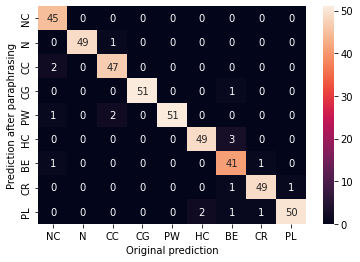

In [14]:

data5 = pd.read_csv("dataset_50.csv")

labels = set(list(data5['label']))

def get_index(x):
    return list(labels).index(x)

import numpy as np; np.random.seed(0)
import seaborn as sns; 

x_axis_labels = list(labels)
y_axis_labels = list(labels)

# create seabvorn heatmap with required labels

data = np.zeros((9, 9))
total = 0 

def add(first, second):
    global total
    data[get_index(second)][get_index(first)] += 1
    if first != second: 
        total += 1

sentences_list = []
paraphrased_list = []
class1_list = []
class2_list = []
correct_list = []

for i in range(len(data5)):
    sentence = data5.loc[i, 'sentence']
    paraphrased = data5.loc[i, 'paraphrased']
    correct_label = data5.loc[i, 'label']
    cls1 = classify(sentence)['label'].strip()
    cls2 = classify(paraphrased)['label'].strip()
    # print(sentence)
    # print(paraphrased)
    add(cls1, cls2)

    if len(set([cls1, cls2])) > 1:
        print(sentence, '*******', paraphrased, cls1, cls2, correct_label)
        sentences_list.append(sentence)
        paraphrased_list.append(paraphrased)
        class1_list.append(cls1)
        class2_list.append(cls2)
        correct_list.append(correct_label)


ax = sns.heatmap(data, annot = True, xticklabels=x_axis_labels, yticklabels=y_axis_labels)
ax.set_xlabel('Original prediction', fontsize=10)
ax.set_ylabel('Prediction after paraphrasing', fontsize=10)

print(total)

In [16]:
df = pd.DataFrame({
    "sentence": sentences_list,
    "paraphrased": paraphrased_list,
    "class_1": class1_list,
    "class_2": class2_list,
    "correct": correct_list,
})

df.to_csv("summary-csv.csv")

df

,sentence,paraphrased,class_1,class_2,correct
0,Diversity and inclusion is a core company valu...,"At all levels, diversity and inclusion are ess...",BE,HC,BE
1,We are now four times safer as a company than ...,"As a corporation, we are now four times safer ...",HC,PL,HC
2,"By increasing crop yields, we help limit the c...",We reduce the conversion of carbon-sequesterin...,NC,CC,NC
3,Reduced transportation fuel usage rate by 25% ...,25% less transportation petroleum has been use...,CC,PW,CC
4,We place the highest importance on maintaining...,The upkeep of global compliance with competiti...,BE,CG,BE
5,"Going forward, Prologis will report progress t...",Prologis will update investors on its progress...,CC,N,CC
6,"In the U.S., we’ve increased our focus on buyi...","In the United States, we now place more emphas...",CR,PL,CR
7,Educational outreach efforts can help keep our...,Outreach programs aimed at educating the publi...,PL,CR,PL
8,Promote the use o f sustainability metrics in ...,Encourage the use of sustainability metrics in...,NC,CC,NC
9,We also operate our plants efficiently using c...,We utilize captured waste heat to efficiently ...,CC,PW,CC
